In [1]:
import os 
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

In [2]:
Dataset_path = "RGB_224x224"

In [3]:
train_dir = os.path.join(Dataset_path, "train")
val_dir = os.path.join(Dataset_path, "val")
test_dir = os.path.join(Dataset_path, "test")

In [4]:
classes = os.listdir(train_dir)

In [5]:
len(classes)

139

In [6]:
classes

['Beets plant',
 'Oranges plant',
 'Maracuja(Passionfruit) plant',
 'Pomegranates plant',
 'Kohlrabi plant',
 'Mangoes, mangosteens, guavas plant',
 'Barley plant',
 'Oregano plant',
 'Brazil nuts plant',
 'Strawberries plant',
 'Okra plant',
 'Aji pepper plant',
 'Rice (Paddy) plant',
 'Swiss chard plant',
 'Hazelnuts plant',
 'Fava bean plant',
 'Coconuts plant',
 'Thyme plant',
 'Pineapples plant',
 'Pumpkins, squash and gourds plant',
 'Black pepper plant',
 'Papayas plant',
 'Saffron plant',
 'Amaranth plant',
 'Lupins plant',
 'Rosemary plant',
 'Dates plant',
 'Sunflower seeds plant',
 'Raspberries plant',
 'Endive plant',
 'Cranberries plant',
 'Lychee plant',
 'Rambutan plant',
 'Sweet potatoes plant',
 'Quinoa plant',
 'Sage plant',
 'Cucumbers and gherkins plant',
 'Mustard seeds plant',
 'Garlic plant',
 'Cinnamon plant',
 'Cauliflower plant',
 'Collards plant',
 'Parsley plant',
 'Mandarins, clementines, satsumas plant',
 'Carrots and turnips plant',
 'Jute plant',
 'Spina

In [7]:
random.sample(classes, 5)

['Starfruit plant',
 'Tea plant',
 'Rapeseed (Canola) plant',
 'Swiss chard plant',
 'Kohlrabi plant']

In [8]:
def show_sample_images(num_classes = 4):
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, 3 * num_classes))
    for i, class_name in enumerate(random.sample(classes, num_classes)):
        class_path = os.path.join(train_dir, class_name)
        image_names = os.listdir(class_path)
        for j in range(5):
            image_name = random.choice(image_names)
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)
            axes[i, j].imshow(np.array(image))
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

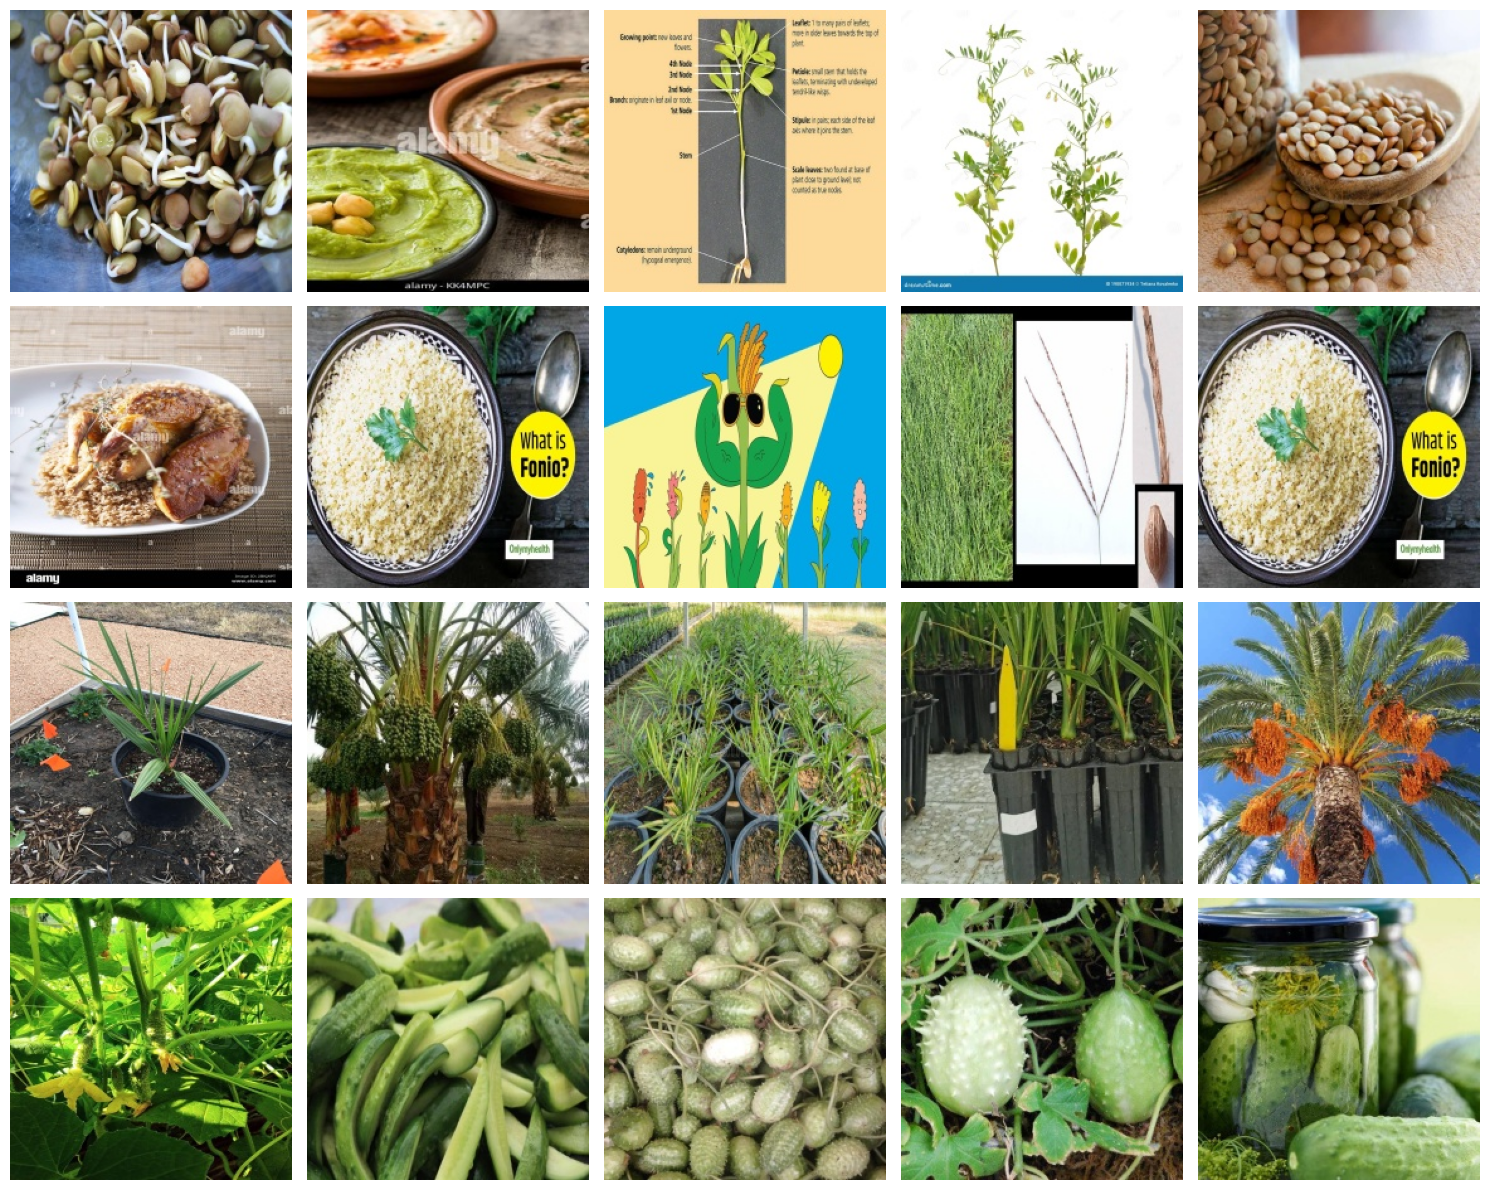

In [11]:
show_sample_images()

In [12]:
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [13]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = ImageFolder(os.path.join(train_dir), transform=transforms)
val_dataset = ImageFolder(os.path.join(val_dir), transform=transforms)
test_dataset = ImageFolder(os.path.join(test_dir), transform=transforms)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [16]:
import torchvision.models as models
import torch.nn as nn

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
model = models.resnet50(pretrained=True)

/home/darshan39/code-for-darshan/ project/Pytorch_project/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/darshan39/code-for-darshan/ project/Pytorch_project/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/darshan39/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [03:02<00:00, 562kB/s] 


In [22]:
for param in model.parameters():
    param.requires_grad = False

In [23]:
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [24]:
import torch.optim as optim 
import torch.nn.functional as F

In [29]:
optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [30]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [31]:
def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/5
Train Loss: 3.1391, Train Acc: 0.3321
Val Loss: 2.6985, Val Acc: 0.4100
Epoch 2/5
Train Loss: 2.5562, Train Acc: 0.4224
Val Loss: 2.6154, Val Acc: 0.4327
Epoch 3/5
Train Loss: 2.3655, Train Acc: 0.4630
Val Loss: 2.5630, Val Acc: 0.4452
Epoch 4/5
Train Loss: 2.2413, Train Acc: 0.4852
Val Loss: 2.5324, Val Acc: 0.4645


In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [ ]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images_shown = 0
    classes = train_dataset.classes
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"Predicted: {classes[predicted[i]]}, Actual: {classes[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1

                if images_shown >= num_images:
                    return

In [ ]:
visualize_predictions(model, test_loader, num_images=3)